# Trajectory Uncertainty

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/gpode/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/gpode/).*

When the vector field $\dot{x} = f(x)$ is a Gaussian process, we have uncertainty in the vector field, which we can lift to the trajectory. In this example we show how to use the approximate `PULL` solvers, introduced in [this paper](https://arxiv.org/abs/2211.11103), to propagate this uncertainty.

## 1D Example
### Setup

In [1]:
using GPDiffEq
using Plots
using LinearAlgebra

In [2]:
using StatsPlots

### Defining a simple GP
In this example we sample the vector field values directly instead of learning them from a trajectory.

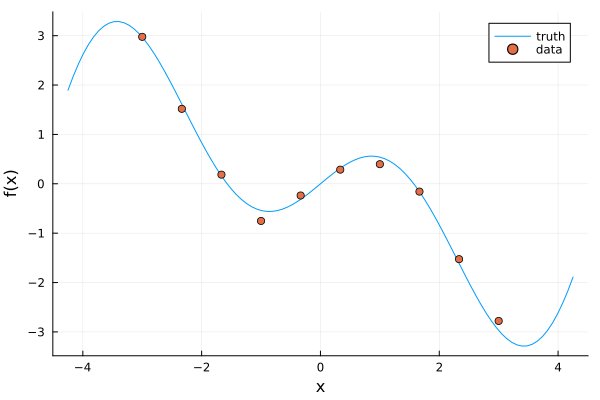

In [3]:
ts = range(-4.25, 4.252; length=100)
f(x) = x * cos(x)

X = range(-3.0, 3.0; length=10)
σ_n = 0.1
y = f.(X) .+ σ_n * randn(length(X))
p = plot(ts, f.(ts); label="truth", xlabel="x", ylabel="f(x)")
scatter!(p, X, y; label="data")

With this data, we define the GP.

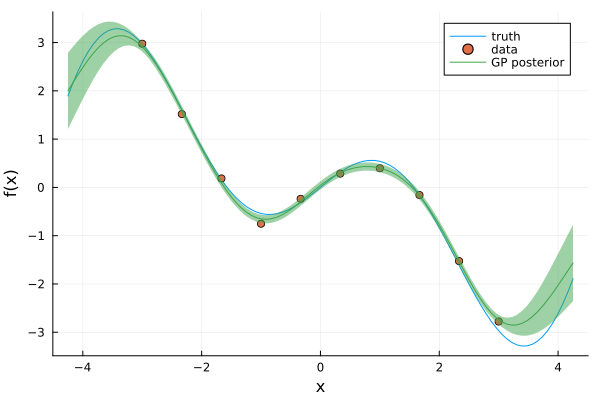

In [4]:
ker = SqExponentialKernel()
gp = GP(ker)
fx = gp(X, σ_n^2)

fp = posterior(fx, y)

plot!(p, ts, mean(fp, ts); ribbons=sqrt.(var(fp, ts)), label="GP posterior")

### A GPODE problem

We define a `GPODEProblem` with the GP as the vector field.

In [5]:
u0 = 1.0
tspan = (0.0, 8.0)
ff = GPODEFunction(fp)

prob = GPODEProblem(ff, u0, tspan)

GPODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 8.0)
u0: 1.0

and integrate with the PULL Euler solver.

In [6]:
sol = solve(prob, PULLEuler(); dt=0.1)
nothing #hide

This results in a trajectory where each state is a normal distribution, and we can plot the trajectories of the means and their standard deviations.

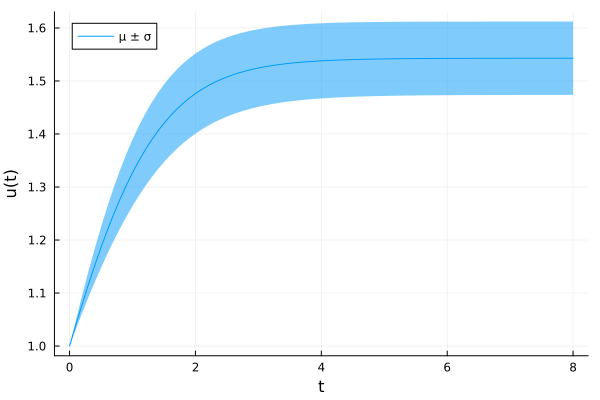

In [7]:
plot(sol.t, mean.(sol.u); ribbons=std.(sol.u), label="μ ± σ", xlabel="t", ylabel="u(t)")

## 2D Example

### Setup

In [8]:
function fun(x)
    return [-0.1 2.0; -2.0 -0.1] * (x .^ 3)
end
xrange = range(-2.2, 2.2; length=6)
x = collect.(Iterators.product(xrange, xrange))[:]
y = fun.(x)
# This is annoying UX, needs fix
y = ColVecs(reduce(hcat, y))
xMO, yMO = prepare_isotopic_multi_output_data(x, y)
nothing #hide

### Defining a Multi-Output GP

In [9]:
σ_n = 3e-2
ker = SqExponentialKernel()
mker = IndependentMOKernel(ker)

gp = GP(mker)
fx = gp(xMO, σ_n)
fp = posterior(fx, yMO)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{Vector{Float64}, Vector{Vector{Float64}}, Int64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}(AbstractGPs.ZeroMean{Float64}(), Independent Multi-Output Kernel
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))), (α = [-29.2124703130299, 32.2874671880857, -7.965684324886952, -23.297037809412693, -16.60262823825942, 17.04785570559112, -18.22035634735454, -15.306706476310413, -5.602061180182959, 23.975425084666156  …  5.602061180182997, -23.975425084666178, 18.22035634735448, 15.306706476310405, 16.602628238259502, -17.04785570559111, 7.965684324886902, 23.2

### A GPODE problem

We define a `GPODEProblem` with the GP as the vector field.

In [10]:
h = 0.002
u0 = [2.0; 0.0]
tspan = (0.0, 2.0)
gpff = GPODEFunction(fp)

(::GPDiffEq.PullSolversModule.GPODEFunction{false, AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{Vector{Float64}, Vector{Vector{Float64}}, Int64}, Vector{Float64}}}}, AbstractGPs.PosteriorGP{GPDiffEq.DerivativeGPModule.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}, AbstractGPs.ZeroMean{Float64}, GPDiffEq.DerivativeGPModule.DerivativeKernelCollection{KernelFunctions.IndependentMOKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{Vector{Float64}, Vector{Vector{Floa

Plot the GP

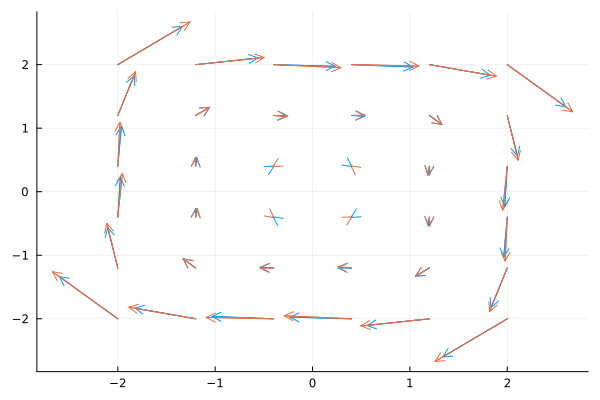

In [11]:
ug = range(-2.0, 2.0; length=6)
ug = vcat.(ug, ug')[:]
gp_pred_mean = gpff.(ug)
sf = maximum(norm.(gp_pred_mean))
dug = fun.(ug)
p = quiver(
    getindex.(ug, 1),
    getindex.(ug, 2);
    quiver=(getindex.(dug, 1) / sf, getindex.(dug, 2) / sf),
)
quiver!(
    p,
    getindex.(ug, 1),
    getindex.(ug, 2);
    quiver=(getindex.(gp_pred_mean, 1) / sf, getindex.(gp_pred_mean, 2) / sf),
)

Define a `GPODEProblem` with the GP as the vector field.

In [12]:
prob = GPODEProblem(gpff, u0, tspan)

GPODEProblem with uType Vector{Float64} and tType Float64. In-place: false
timespan: (0.0, 2.0)
u0: 2-element Vector{Float64}:
 2.0
 0.0

Solving it with a non-PULL method uses the vector field defined by the mean of the GP.

In [13]:
det_gpsol = solve(prob, Euler(); dt=h)
nothing #hide

However, integrating with the PULL Euler solver returns a trajectory where each state is a multi-variate normal distribution.

In [14]:
gpsol = solve(prob, PULLEuler(); dt=h)
nothing #hide

#### Time series
We visualize the trajectories as time series, showing the standard deviation of each component.

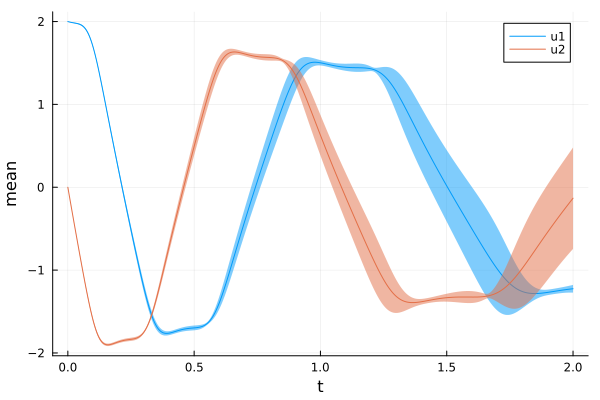

In [15]:
m = mean.(gpsol.u)
s = var.(gpsol.u)
plot(
    gpsol.t,
    getindex.(m, 1);
    ribbons=sqrt.(getindex.(s, 1)),
    label="u1",
    xlabel="t",
    ylabel="mean",
)
plot!(gpsol.t, getindex.(m, 2); ribbons=sqrt.(getindex.(s, 2)), label="u2")

#### Phase plot
The components of each state are not independent, which we show in the phase plot by showing the ellipses of the covariance matrix for a subset of states.

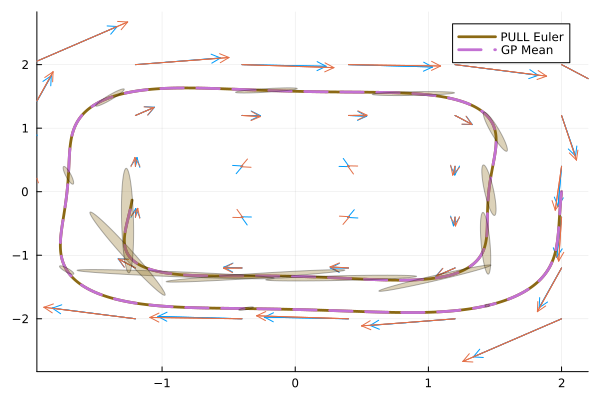

In [16]:
μ_res = mean.(gpsol.u)
ell_intervall = 60
begin
    p2 = deepcopy(p)
    plot!(
        p2,
        getindex.(μ_res, 1),
        getindex.(μ_res, 2);
        linewidth=2.8,
        label="PULL Euler",
        color=:goldenrod4,
    )
    plot!(p2, det_gpsol; idxs=(1, 2), linewidth=2.8, label="GP Mean", linestyle=:dash)

    for i in 1:ell_intervall:length(gpsol.u)
        mv = gpsol[i]
        covellipse!(p2, mv.μ, 2 * mv.Σ; label="", color=:goldenrod4)
    end
    p2
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*